In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.neighborlist import neighbor_list
from ase.io.trajectory import Trajectory
from numpy.random import default_rng
import matplotlib.pyplot as plt
import pickle as pck

import matplotlib.pyplot as plt
import torch

In [3]:
from utils import MLPClassifier, evaluate_classification, PTMinMaxScaler, split_data, train, pca

In [4]:
from numpy import pi, cos, exp

# cutoff function
def cutoff_fc(dist, rmin, rmax):
    dist = torch.asarray(dist)
    fc = torch.ones_like(dist)
    mask = dist > rmin
    fc[mask] = 0.5*(cos((dist[mask]-rmin)*pi/(rmax-rmin)) + 1.0)
    fc[dist >= rmax] = 0.
    return fc

# G1
def G1(dist, rmin, rmax):
    g1 = torch.sum(cutoff_fc(dist,rmin,rmax))
    return g1

# G2
def G2(dist, rmin, rmax, Rs, eta):
    fc = cutoff_fc(dist,rmin,rmax)
    dist = torch.asarray(dist)
    dr = dist - Rs
    g2 = torch.sum(exp(-eta*dr*dr)*fc)
    return g2

# G3
def G3(dist, rmin, rmax, kappa):
    fc = cutoff_fc(dist,rmin,rmax)
    dist = torch.asarray(dist)
    g3 = torch.sum(cos(dist*kappa)*fc)
    return g3

In [5]:
# parameter sets
# g1
rmin = 2.6
rmax = 2.8

# g2
Rs_eta_para = [[2.0,2.0], [1.6, 10.0], [2.2, 10.0], [2.4,10.0], [1.9,100.0]]

# for Rs_eta in Rs_eta_para:
#     print(Rs_eta[0],Rs_eta[1])

# g3
kappa_para = [1.5, 2.0, 3.0, 8.0, 8.5]

n_features = 11
# intialize random number generator
rng = default_rng(47)

# set neighbour list cutoff
cutoff = 3

# here all the descriptors are saved
g = {}


# loop over the 4 bulk
for s in 'fcc_600k', 'bcc_600k', 'hcp_600k', 'liquid_3000k', 'fcc_300k':
    straj =  s + '.traj'
    print(straj)
    # read trajectory
    traj = Trajectory(straj, 'r')
    g[s] = torch.empty((2000, n_features))

    nslices = len(traj)
    natoms = len(traj[0])

    print(f'Number of trajectory slices = {nslices}')
    print(f'Number of atoms = {natoms}')

    # pick ns random slices
    ns = 10  
    # number of atoms picked per slice
    na = 200

    sliceind = rng.integers(50,nslices,size=ns)

    ifeat = 0
    for k in sliceind:
        print(k)
        # get neighbour list
        i, j, r_ij = neighbor_list('ijd', traj[k], cutoff, self_interaction=False)
        # randomly pick na atoms
        atomind = rng.integers(natoms,size=na)
        # loop over all atoms and compute set of symmetry functions and append to collection
        for ti in atomind:
            g_tmp = []
            g_tmp.append(G1(r_ij[i==ti],rmin,rmax))
            
            for Rs_eta in Rs_eta_para: 
                g_tmp.append(G2(r_ij[i==ti],rmin,rmax,Rs_eta[0],Rs_eta[1]))
                
            for kappa in kappa_para:
                g_tmp.append(G3(r_ij[i==ti],rmin,rmax,kappa))
            
            g[s][ifeat]=(torch.tensor(g_tmp).type(torch.float32))
            ifeat += 1


fcc_600k.traj
Number of trajectory slices = 101
Number of atoms = 1372
54
87
77
88
71
73
55
55
54
99
bcc_600k.traj
Number of trajectory slices = 101
Number of atoms = 1024
58
52
71
81
88
73
98
88
93
76
hcp_600k.traj
Number of trajectory slices = 101
Number of atoms = 1134
85
99
86
56
58
55
55
86
63
90
liquid_3000k.traj
Number of trajectory slices = 101
Number of atoms = 1000
79
74
73
61
51
96
58
99
53
65
fcc_300k.traj
Number of trajectory slices = 101
Number of atoms = 1372
50
59
85
91
86
71
74
94
81
68


In [6]:
len(g['fcc_600k'])

2000

In [6]:
with open('allG.pck', 'wb') as f:
    pck.dump(g, f)

In [8]:
import numpy as np

In [7]:
[k for k in g]

['fcc_600k', 'bcc_600k', 'hcp_600k', 'liquid_3000k', 'fcc_300k']

In [9]:
X_train = torch.concatenate([g['fcc_600k'], g['bcc_600k'], g['hcp_600k'], g['liquid_3000k']])
X_test = torch.concatenate([g["fcc_300k"] ])

In [10]:
X_train.shape, X_test.shape

(torch.Size([8000, 11]), torch.Size([2000, 11]))

In [11]:
n_samples_per_class = 2000
n_classes = 4

In [12]:
y_train = torch.repeat_interleave(torch.arange(n_classes),n_samples_per_class)
y_test = torch.zeros(n_samples_per_class)

In [14]:
y_train.shape

torch.Size([8000])

In [15]:
X_train.shape, y_train.shape

(torch.Size([8000, 11]), torch.Size([8000]))

(array([3.986e+03, 3.690e+02, 1.077e+03, 5.630e+02, 5.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.400e+01, 1.020e+02, 3.290e+02, 5.120e+02,
        5.230e+02, 3.200e+02, 1.460e+02, 4.100e+01, 1.000e+01, 2.200e+01,
        1.260e+02, 3.470e+02, 7.190e+02, 1.789e+03, 1.085e+03, 2.931e+03,
        8.180e+02, 3.300e+03, 1.513e+03, 2.224e+03, 1.102e+03, 6.360e+02,
        6.510e+02, 5.620e+02, 3.590e+02, 2.530e+02, 2.350e+02, 3.470e+02,
        4.390e+02, 1.505e+03, 1.363e+03, 3.960e+02, 4.050e+02, 2.740e+02,
        1.950e+02, 1.610e+02, 1.780e+02, 3.620e+02, 6.800e+02, 7.450e+02,
        1.124e+03, 1.260e+03, 1.255e+03, 5.690e+02, 2.430e+02, 1.960e+03,
        5.182e+03, 1.564e+03, 6.210e+02, 9.060e+02, 2.373e+03, 2.722e+03,
        3.835e+03, 1.546e+03, 2.740e+03, 1.641e+03, 1.702e+03, 3.191e+03,
        3.849e+03, 3.300e+01, 1.180e+02, 3.210e+02, 6.100e+02, 6.000e+02,
        2.690e+02, 4.300e+01, 3.000e+00, 0.000e+00, 1.000e+00, 7.000e+00,
        3.000e+01, 6.600e+02, 1.506e+0

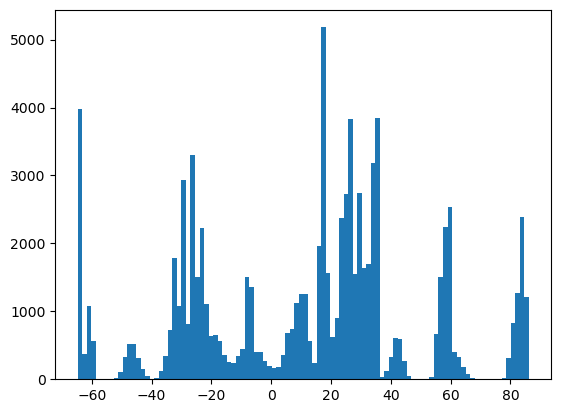

In [16]:
plt.hist(X_train.detach().numpy().flatten(),bins=100)

## Training

In [13]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [14]:
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [19]:
import numpy as np

In [19]:
# X = X.type(torch.float32)
# y = y.type(torch.LongTensor)

In [15]:
# fit the scaler
x_scaler = PTMinMaxScaler(X_train, 1. , 0.)
X_train_scaled = x_scaler.scale(X_train)
X_test_scaled = x_scaler.scale(X_test)

In [55]:
np.__version__

'1.26.2'

In [16]:

all_data, train_data, test_data = split_data(X_train, y_train, .75, DEVICE)
all_data_scaled, train_data_scaled, test_data_scaled = split_data(X_train_scaled, y_train, .75, DEVICE)
print("The length of train data is:",len(train_data))
print("The length of test data is:",len(test_data))

The length of train data is: 6000
The length of test data is: 2000


In [17]:
# put datasets into dataloaders
batch_size = 25
train_loader = DataLoader(train_data_scaled, 
                         batch_size=batch_size, 
                         shuffle=True)
test_loader = DataLoader(train_data_scaled, 
                         batch_size=batch_size, 
                         shuffle=True)

In [18]:
model  = MLPClassifier([11,100,100,100,4])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

MLPClassifier(
  (_layers): Sequential(
    (0): Linear(in_features=11, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=4, bias=True)
  )
)


In [19]:
losses = []

In [20]:
X_train.dtype, y_train.dtype

(torch.float32, torch.int64)

In [21]:
a = torch.arange(6).reshape(2,3)
a

tensor([[0, 1, 2],
        [3, 4, 5]])

In [22]:
torch.max(a,dim=-1)[0]

tensor([2, 5])

In [23]:

log_interval = 10
for epoch in range(100):
    loss_train = train(model, train_loader,optimizer, criterion,DEVICE)
      
    if epoch % log_interval == 0:
        loss_eval, accuracy = evaluate_classification(model,
                                            criterion,
                                            test_loader,DEVICE)
        print(f'Train Epoch: {epoch}')
        print(f'Loss (train): {loss_train:.6f}')
        print(f'Loss (eval): {loss_eval:.6f}')
        print(f'Accuracy: {accuracy:.1f} % i.e. \
                {int(accuracy / 100 * len(test_loader.dataset))} / {len(test_loader.dataset)} \n')
    losses.append(loss_train)

/home/psireal42/study/ml-mol-physics/UB12/utils.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self._layers(x))


Train Epoch: 0
Loss (train): 1.184858
Loss (eval): 0.944022
Accuracy: 90.5 % i.e.                 5429 / 6000 

Train Epoch: 10
Loss (train): 0.743996
Loss (eval): 0.743791
Accuracy: 100.0 % i.e.                 6000 / 6000 

Train Epoch: 20
Loss (train): 0.743706
Loss (eval): 0.743697
Accuracy: 100.0 % i.e.                 6000 / 6000 

Train Epoch: 30
Loss (train): 0.743679
Loss (eval): 0.743692
Accuracy: 100.0 % i.e.                 6000 / 6000 

Train Epoch: 40
Loss (train): 0.743673
Loss (eval): 0.743671
Accuracy: 100.0 % i.e.                 6000 / 6000 

Train Epoch: 50
Loss (train): 0.743682
Loss (eval): 0.743675
Accuracy: 100.0 % i.e.                 6000 / 6000 

Train Epoch: 60
Loss (train): 0.743672
Loss (eval): 0.743670
Accuracy: 100.0 % i.e.                 6000 / 6000 

Train Epoch: 70
Loss (train): 0.743669
Loss (eval): 0.743669
Accuracy: 100.0 % i.e.                 6000 / 6000 

Train Epoch: 80
Loss (train): 0.743669
Loss (eval): 0.743669
Accuracy: 100.0 % i.e.       

In [24]:
torch.save(model.state_dict(), "model_classifier.torch")

In [31]:
ids = test_data_scaled.y.argsort()

In [32]:
with torch.no_grad():
    y_out = model(test_data_scaled.x[ids])

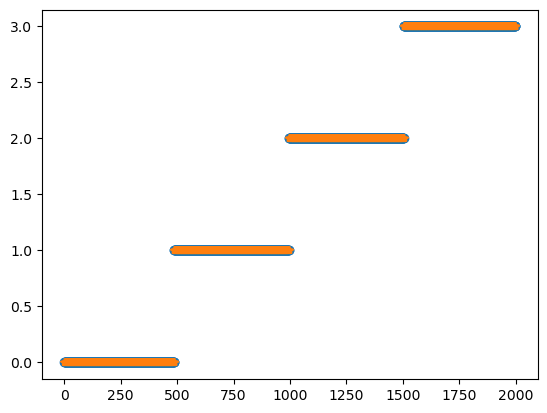

In [33]:
plt.plot(test_data_scaled.y[ids],'o')
plt.plot(y_out.data.max(1)[1],'*')

In [34]:

# first/second principal components
traj_projected, eigvecs = pca(X_train_scaled.detach().numpy(), 2)
dxy = eigvecs[0]
dxy1 = eigvecs[1]

In [35]:
traj_projected.shape

(8000, 2)

In [36]:
cdict = {0: 'yellow', 1: 'red', 2: 'blue', 3: 'green'}


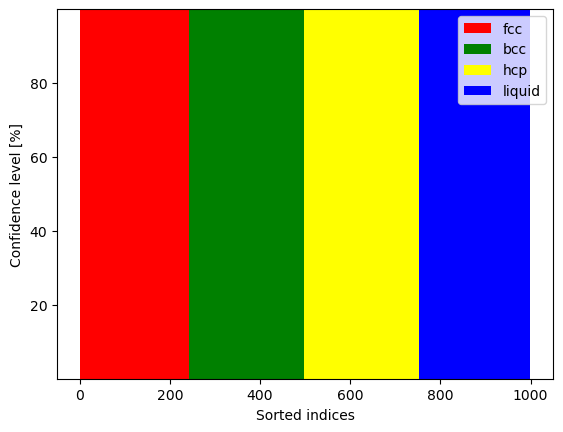

In [42]:
import numpy as np

with torch.no_grad():
    y_out = model(test_data_scaled.x[ids])

results = y_out.detach().numpy() * 100
colors = ["red", "green", "yellow", "blue"]
names = ["fcc", "bcc", "hcp", "liquid"]
fig, ax = plt.subplots()
x_placement = np.arange(len(results)) * 0.5
bottoms = np.zeros_like(x_placement)

for color, name, result in zip(colors, names, results.T):
    ax.bar(x_placement, result, bottom=bottoms, width=0.5, color=color, label=name)
    bottoms += result

ax.legend()
ax.set_xlabel("Sorted indices")
ax.set_ylabel("Confidence level [%]")
plt.show()

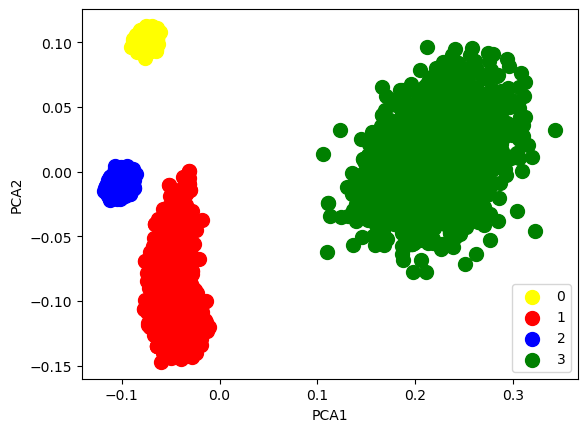

In [37]:
fig, ax = plt.subplots()
for g in np.unique(y_train):
    ix = np.where(y_train == g)
    ax.scatter(traj_projected[ix,0],traj_projected[ix,1], c = cdict[g], label = g, s = 100)
ax.legend()
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
plt.show()

## Get probabilities for 300 K structure

In [71]:
with torch.no_grad():
    y_out = model(test_data_scaled.x[ids])

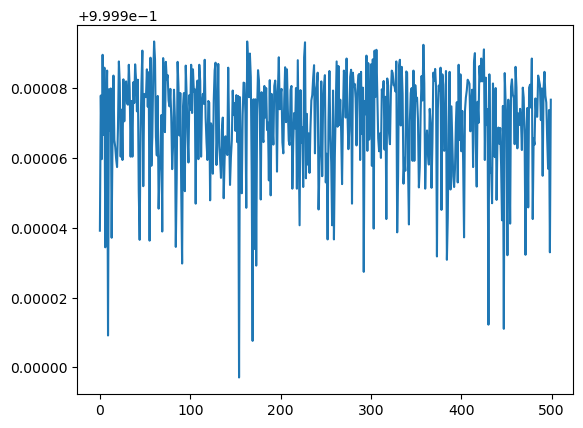

In [76]:
plt.plot(y_out[:500,0])

In [74]:
with torch.no_grad():
    y_out = model(X_test_scaled)

/srv/data/schebem94/PhD/codes/ml-tutorial/WiSe-2023/exercises/ex12/utils.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(self._layers(x))


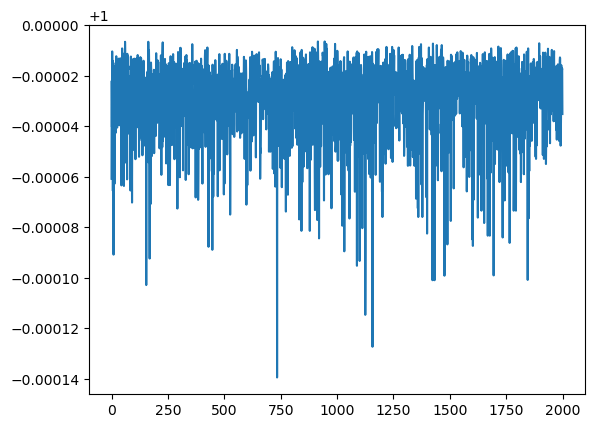

In [75]:
plt.plot(y_out[:,0])
